- Determine which variables have linear relationship with price
- Determine which are highly correlated with each other
- Engineer more features
- Clean the data


- Engineer features
- Non-linear relationships
- Whittle down dataset
- Adjust features if necessary
- Data Cleaning
- Collinearity

# Stakeholder

A real estate company is looking to invest in non-luxury, single-family homes in King County, WA. They think this market will grow over time. They want information on several factors that influence the price of such homes.

In this project I define a non-luxury, single-family home as a house less than $3 million dollars, with over 1500 square feet of living space, and 3 or more bedrooms.

In [108]:
import pandas as pd
pd.set_option('display.max_columns', 500)

from matplotlib import pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_rainbow
import scipy.stats as stats
from scipy.stats import kstest
from scipy.stats import shapiro
from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools
import plotly.express as px
import geopy.distance
from IPython.display import clear_output

In [109]:
houses = pd.read_csv("data/kc_house_data.csv")

# Functions

I list all the functions I use in this project here. As a result, the rest of the project will be more readable.

In [110]:
def scatter(df, cols):
    fig, ax = plt.subplots(4,5, figsize=(25,15))
    fig.tight_layout(pad=3)

    for i in range(20):

        row = i//5
        col=i%5

        try:
            ax[row][col].scatter(df[cols[i]], df.price)
            ax[row][col].set_title(cols[i], size=15)
        except:
            break

In [111]:
def hist(df, cols):
    fig, ax = plt.subplots(1,5, figsize=(25,5))
    fig.tight_layout(pad=5.0)

    for i in range(5):

        row = i//5
        col=i%5

        ax[i].hist(df[cols[i]], bins=100)
        ax[i].set_title(cols[i], size=25)

In [112]:
def value_counts(df, cols):
    
    for col in cols:
        value_counts = dict(df[col].value_counts())
        for key in value_counts.keys():
            if value_counts[key] <= 10:
                df = df[~(df[col] == key)]
                
    return df

In [113]:
def variable_strength(df, var_list):
    col_dict = {"variables": var_list, "rsquared_adj": []}

    for col in var_list:
        model = sm.OLS.from_formula(f"price ~ {col}", data=df)
        results = model.fit()
        col_dict["rsquared_adj"].append(results.rsquared_adj)

    return pd.DataFrame(col_dict).sort_values(by="rsquared_adj", ascending=False)

# Feature Engineering

In this section we will create five new variables for our model based on the variables we already have: the average price by zipcode, and the density of the zipcode (how crowded it is).

A house's zipcode allows us to see how nearby houses are priced. This could be useful information in determining the price of a house. The density of a zipcode determines how crowded it is; this could also be a factor in how a house is priced.

The zipcodes are contained in the "address" variable. Each address is formatted like this:

``'houses number + street, city, state + zipcode, country'``

Extracting the zipcode only requires a pandas **map** method and python's built-in string-splitting functionality.

Once the zipcode is extracted, it will be placed in a column of its own. Then, for each house, we will calculate the average house price in its zipcode. Each house's price will be excluded from its own average, to avoid a house helping to predict its own price.

The density will just be the number of houses in the zipcode. We will only include zipcodes with more than 50 houses; this is an arbitrary cutoff point to ensure we are working with sufficient data. There were 73 unique zipcodes in total that had >50 houses.

In [114]:
houses['patio'] = houses['sqft_patio'].map(lambda x: 0 if x == 0 else 1)
houses['basement'] = houses['sqft_basement'].map(lambda x: 0 if x == 0 else 1)
houses['garage'] = houses['sqft_garage'].map(lambda x: 0 if x == 0 else 1)

In [115]:
houses['grade'] = houses['grade'].map(lambda x: x.split(" ")[0]).astype(int)
houses['waterfront'] = houses['waterfront'].map({'NO': 0, 'YES': 1})
houses['greenbelt'] = houses['greenbelt'].map({'NO': 0, 'YES': 1})
houses['nuisance'] = houses['nuisance'].map({'NO': 0, 'YES': 1})
houses['view'] = houses['view'].map({'NONE': 0, 'AVERAGE': 1, 'GOOD': 2, 'EXCELLENT': 3, 'FAIR': 4})
houses['condition'] = houses['condition'].map({'Poor': 0, 'Fair': 1, 'Average': 2, 'Good': 3, 'Very Good': 4})

In [116]:
houses['zipcode'] = houses.address.map(lambda x: x.split(',')[-2].split(' ')[-1])

zipcode_prices = []
for i in range(len(houses)):
    zipcode = houses.iloc[i].zipcode
    identifier = houses.iloc[i].id
    subset = houses[(houses.zipcode == zipcode) & (houses.id != identifier)]
    zipcode_price = subset.price.mean()
    zipcode_prices.append(zipcode_price)
    clear_output(wait=True)
    print(f"cell number {i} done.")
    
houses['zipcode_price'] = zipcode_prices

cell number 30154 done.


In [117]:
houses['density'] = houses.zipcode.map(dict(houses.zipcode.value_counts()))

In [118]:
# Creating a "coordinate" variable in a lat/long tuple format.
houses['coordinate'] = list(zip(houses['lat'], houses['long']))

# This calculates the distance of every house from the center of inhabited territory.
center = ((houses.lat.min() + houses.lat.max())/2), ((houses.long.min() + houses.long.max())/2)
houses['distance_from_center'] = houses['coordinate'].map(lambda x: geopy.distance.geodesic(x, center).km)

highest_price = (47.62637851929106, -122.22555549295355)
houses['distance_from_bellevue'] = houses['coordinate'].map(lambda x: geopy.distance.geodesic(x, highest_price).km)

In [119]:
lat_square = (47.213232398310396 - 47.1992389962046)
long_square = (-121.38307527465054 - -121.3939406543853)

# For every house, we calculate how many houses are in a square-shaped area around them.
# Also, we calculate the average price of houses in that area.
# From this data we get average price of houses in the vicinity as well as the density of that area.
# The house whose price we are trying to predict is eliminated from the mean vicinity price.
# Only houses sold before the target house are included in the mean price.

lengths = []
vicinity_means = []

for i in range(len(houses)):
    lat, long = houses.iloc[i].lat, houses.iloc[i].long
    area = houses[(houses.lat < lat+lat_square) & 
                  (houses.lat > lat-lat_square) & 
                  (houses.long < long+long_square) & 
                  (houses.long > long-long_square) & 
                  (houses.long != long) & 
                  (houses.lat != lat)]

    lengths.append(len(area))
    vicinity_means.append(area.price.mean())
    
    clear_output(wait=True)
    print(f"cell number {i} done.")

cell number 30154 done.


In [120]:
houses['vicinity_density'] = lengths
houses['vicinity_price'] = vicinity_means

# Non-Linear Relationships with Price

The following variables have a non-linear relationship with price:

- Bedrooms
- Sqft_lot
- Sqft_garage
- Floors
- view
- density

The rest are roughly linear. The "floors" variable could be interpreted as having a negative linear relationship with price, but this makes no sense: how does a house's price go down when the number of floors go up? Such a relationship is suspect and I will therefore not include this variable in my model.

Before eliminating any variables from the dataset, I will use the "bedrooms" variable to include only the type of home we are looking at in this project: non-luxury, single-family homes. (Remember, we defined such a home to have 3 or more bedrooms, more than 1500 square feet of living space, and cost less than 3 million dollars.)

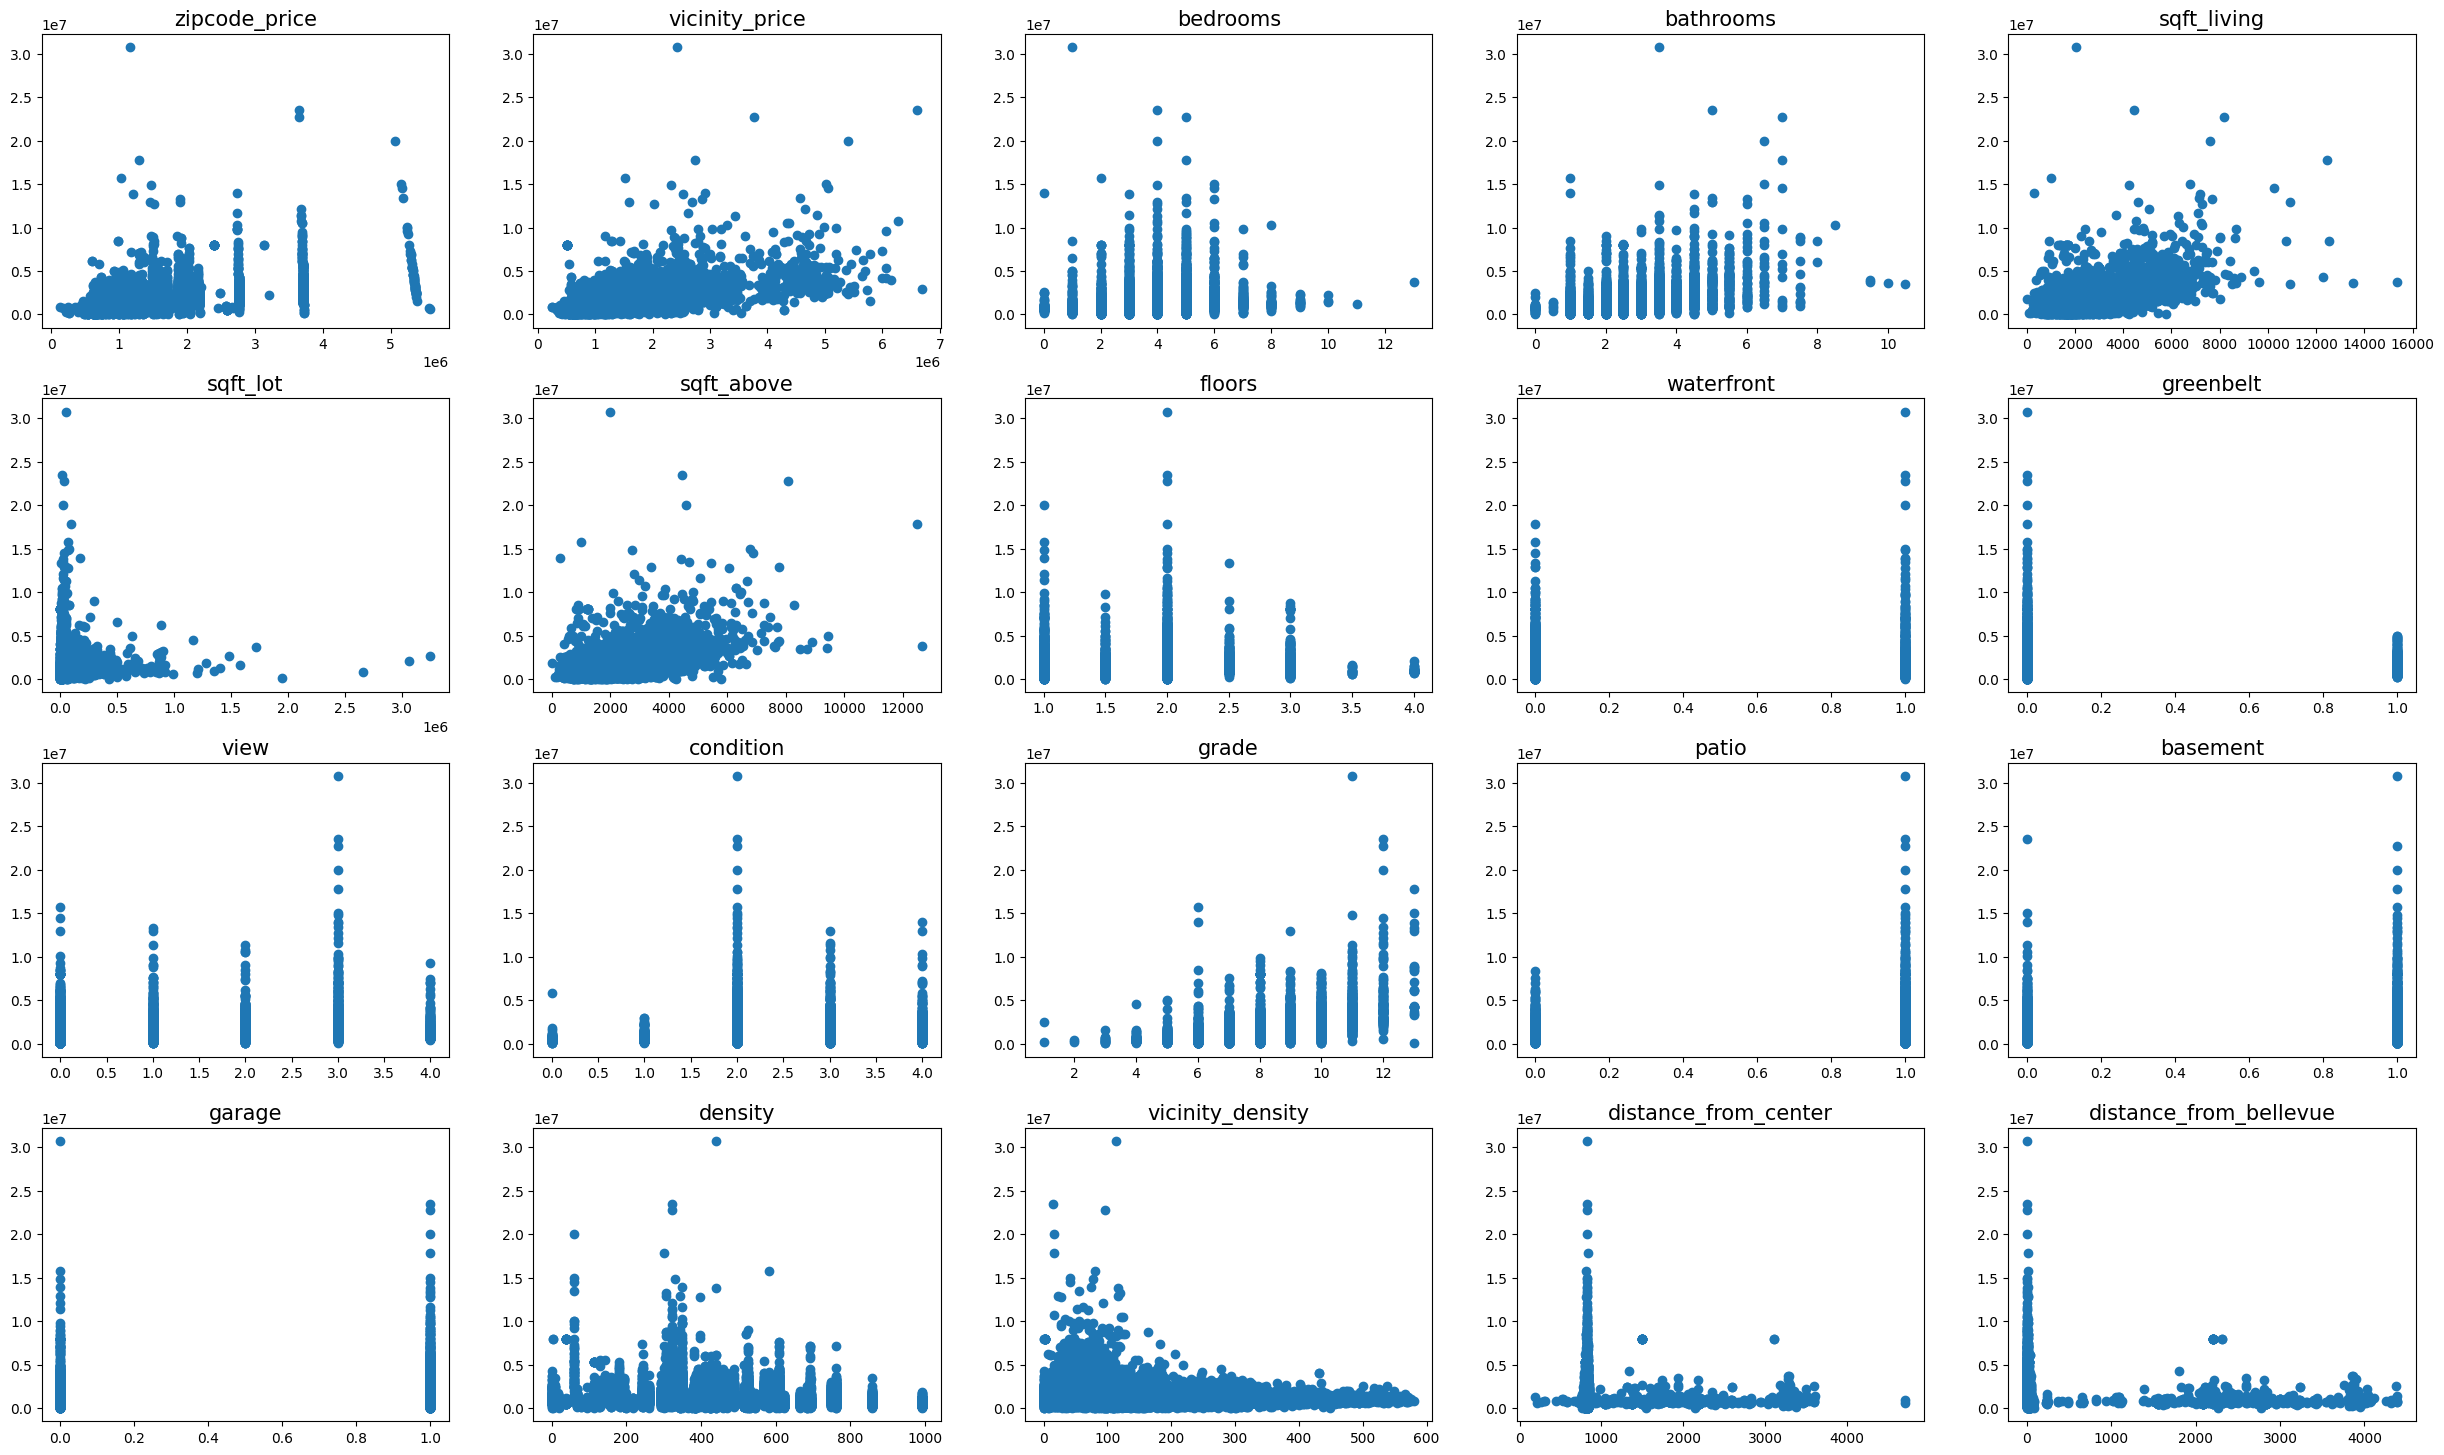

In [121]:
cols = ['zipcode_price', 'vicinity_price', 'bedrooms', 
        'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 
        'floors', 'waterfront', 'greenbelt', 'view', 
        'condition', 'grade', 'patio', 'basement', 'garage', 
        'density', 'vicinity_density', 'distance_from_center', 'distance_from_bellevue']

scatter(houses, cols)

# Data Cleaning

In [122]:
houses = houses.drop(houses.query('bedrooms < 3 or \
                      sqft_living < 1500 or\
                      price > 3_000_000').index)

In [123]:
houses = houses.query('long > -125 & long < -120 & lat > 47 & lat < 48')

In [124]:
cols = ['bedrooms', 'bathrooms', 'floors', 'condition', 'view', 'grade']
houses = value_counts(houses, cols)

In [125]:
houses = houses[houses.groupby('zipcode')['zipcode'].transform('count') > 50]

In [126]:
houses = houses[houses.vicinity_density >= 5]

In [127]:
houses = houses.dropna()

# Eliminating Collinearity

Variables we are not using:

- Bedrooms
- Sqft_lot
- Sqft_garage
- Floors
- view
- density

In [128]:
var_list = ['bathrooms', 'sqft_living', 'waterfront', 'greenbelt', 'nuisance', 'condition', 'grade', 'sqft_above', 'patio', 'basement', 'garage', 'zipcode_price', 'distance_from_center', 'distance_from_bellevue', 'vicinity_density', 'vicinity_price']
strengths = variable_strength(houses, var_list)
strengths

,variables,rsquared_adj
15,vicinity_price,0.502343
11,zipcode_price,0.430291
6,grade,0.337514
1,sqft_living,0.316983
13,distance_from_bellevue,0.228598
7,sqft_above,0.202952
0,bathrooms,0.156119
12,distance_from_center,0.063004
8,patio,0.010615
3,greenbelt,0.010005


In [129]:
houses[list(strengths['variables'])].corr(numeric_only = True)

,vicinity_price,zipcode_price,grade,sqft_living,distance_from_bellevue,sqft_above,bathrooms,distance_from_center,patio,greenbelt,waterfront,vicinity_density,basement,garage,condition,nuisance
vicinity_price,1.000000,0.907211,0.385298,0.279136,-0.571127,0.209500,0.182182,0.242742,0.040677,0.095901,-0.020153,-0.161538,0.053056,0.018500,0.026415,0.067449
zipcode_price,0.907211,1.000000,0.310039,0.213706,-0.597549,0.146734,0.147804,0.262340,0.023514,0.066606,-0.035255,-0.089198,0.065546,0.002176,0.040735,0.077460
grade,0.385298,0.310039,1.000000,0.642177,-0.077489,0.641254,0.477675,-0.060524,0.155550,0.120804,0.029385,-0.190178,-0.154361,0.278271,-0.180609,-0.071742
sqft_living,0.279136,0.213706,0.642177,1.000000,-0.011811,0.797798,0.636587,-0.100983,0.178808,0.110777,0.047110,-0.232745,-0.016865,0.163154,-0.101453,-0.041396
distance_from_bellevue,-0.571127,-0.597549,-0.077489,-0.011811,1.000000,0.140828,-0.023763,-0.759808,0.050700,-0.001211,0.068295,-0.329637,-0.327256,0.198473,-0.059119,-0.166099
sqft_above,0.209500,0.146734,0.641254,0.797798,0.140828,1.000000,0.503453,-0.273490,0.143306,0.130566,0.023055,-0.301260,-0.497538,0.257593,-0.235107,-0.100992
bathrooms,0.182182,0.147804,0.477675,0.636587,-0.023763,0.503453,1.000000,-0.058708,0.179198,0.074278,0.029128,-0.114923,0.021949,0.221924,-0.085939,-0.027742
distance_from_center,0.242742,0.262340,-0.060524,-0.100983,-0.759808,-0.273490,-0.058708,1.000000,-0.088713,-0.109269,-0.039654,0.480545,0.401459,-0.279357,0.070001,0.168576
patio,0.040677,0.023514,0.155550,0.178808,0.050700,0.143306,0.179198,-0.088713,1.000000,0.044032,0.032366,-0.096522,0.017574,0.087622,-0.038052,-0.051585
greenbelt,0.095901,0.066606,0.120804,0.110777,-0.001211,0.130566,0.074278,-0.109269,0.044032,1.000000,-0.019786,-0.093622,-0.065847,0.091644,-0.039210,-0.056241


Looking at this correlation matrix, we gather that:

- vicinity_price is highly correlated with zipcode_price, dropping zipcode_price.
- sqft_living is highly correlated with sqft_above, dropping sqft_above.
- distance_from_bellevue is strongly *negatively* correlated with distance_from_center, dropping distance_from_center.

List of variables we are interested in:

- vicinity_price
- bathrooms
- grade
- sqft_living
- distance_from_bellevue
- 

# Model 1

In [130]:
model = sm.OLS.from_formula(f"price ~ vicinity_price", data=houses)
results = model.fit()
print(results.summary())
print("\n\n")
mae = mean_absolute_error(houses.price, results.predict(houses))
rmse = mean_squared_error(houses.price, results.predict(houses))
print (f"MAE: {mae}\nRMSE: {rmse}")

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                 1.951e+04
Date:                Thu, 22 Jun 2023   Prob (F-statistic):               0.00
Time:                        14:55:03   Log-Likelihood:            -2.7650e+05
No. Observations:               19328   AIC:                         5.530e+05
Df Residuals:                   19326   BIC:                         5.530e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2.772e+05   6819.277     40.

# Model 2

In [131]:
model = sm.OLS.from_formula(f"price ~ vicinity_price + grade + sqft_living + bathrooms + distance_from_bellevue + vicinity_density", data=houses)
results = model.fit()
print(results.summary())
print("\n\n")
mae = mean_absolute_error(houses.price, results.predict(houses))
rmse = mean_squared_error(houses.price, results.predict(houses))
print (f"MAE: {mae}\nRMSE: {rmse}")

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     7453.
Date:                Thu, 22 Jun 2023   Prob (F-statistic):               0.00
Time:                        14:55:03   Log-Likelihood:            -2.7166e+05
No. Observations:               19328   AIC:                         5.433e+05
Df Residuals:                   19321   BIC:                         5.434e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -7.63

# Model 3

In [132]:
to_log = ['price', 'vicinity_price', 'sqft_living', 'distance_from_bellevue', 'vicinity_density']

log_dict = {'logged vars': ["none"] + to_log, 
            'rsquared_adj': [0.698], 
            'mae': [215883.25147031213], 
            'rmse': [94614617291.437], 
            'rsquared_change': [0], 
            'mae_change': [0], 
            'rmse_change': [0]}

for log in to_log:
    
    houses_log = houses.copy()
    houses_log[log] = np.log(houses_log[log])
    
    model = sm.OLS.from_formula(f"price ~ vicinity_price + grade + sqft_living + bathrooms + distance_from_bellevue + vicinity_density", data=houses_log)
    results = model.fit()
    
    mae = mean_absolute_error(houses_log.price, results.predict(houses_log))
    rmse = mean_squared_error(houses_log.price, results.predict(houses_log))
    rsquared_adj = results.rsquared_adj
    
    log_dict['rsquared_adj'].append(rsquared_adj)
    log_dict['mae'].append(mae)
    log_dict['rmse'].append(rmse)
    
    log_dict['rsquared_change'].append(rsquared_adj - 0.698)
    log_dict['mae_change'].append(mae - 215883.25147031213)
    log_dict['rmse_change'].append(rmse - 94614617291.437)

In [133]:
pd.DataFrame(log_dict)

,logged vars,rsquared_adj,mae,rmse,rsquared_change,mae_change,rmse_change
0,none,0.698000,215883.251470,9.461462e+10,0.000000,0.000000,0.000000e+00
1,price,0.596219,0.200905,1.033515e-01,-0.101781,-215883.050565,-9.461462e+10
2,vicinity_price,0.705442,216684.958277,9.234374e+10,0.007442,801.706807,-2.270875e+09
3,sqft_living,0.695124,218888.870615,9.557865e+10,-0.002876,3005.619145,9.640351e+08
4,distance_from_bellevue,0.695311,215755.524568,9.552006e+10,-0.002689,-127.726903,9.054433e+08
5,vicinity_density,0.696477,216767.738146,9.515429e+10,-0.001523,884.486676,5.396724e+08


In [134]:
to_log = ['vicinity_price']
houses_log = houses.copy()
for col in to_log:
    houses_log[col] = np.log(houses_log[col])

In [135]:
model = sm.OLS.from_formula(f"price ~ vicinity_price + grade + sqft_living + bathrooms + distance_from_bellevue + vicinity_density", data=houses_log)
results = model.fit()
print(results.summary())
print("\n\n")
mae = mean_absolute_error(houses_log.price, results.predict(houses_log))
rmse = mean_squared_error(houses_log.price, results.predict(houses_log))
print (f"MAE: {mae}\nRMSE: {rmse}")

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     7715.
Date:                Thu, 22 Jun 2023   Prob (F-statistic):               0.00
Time:                        14:55:03   Log-Likelihood:            -2.7143e+05
No. Observations:               19328   AIC:                         5.429e+05
Df Residuals:                   19321   BIC:                         5.429e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -9.33